In [5]:
# import the libraries
import influxdb 
import pandas as pd
from dateutil import tz
import numpy as np

import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


from pipedream_solver.hydraulics import SuperLink
from pipedream_solver.simulation import Simulation

import seaborn as sns
sns.set_palette('husl')


%matplotlib inline

#upload pipedream model information 
superjunctions=pd.read_csv('waller_creek_superjuctions.csv')  
superlinks=pd.read_csv('waller_creek_superlinks.csv')  
superlinks.index=superlinks['id']

################# set up Waller creek model################### 
subbasins = pd.read_excel('Waller_HMS_model_data.xlsx', sheet_name=0)
ft_to_m = 0.3048



## Import rain data

In [49]:
start_time='20220818 05:00:00'
end_time ='20220819 04:00:00'

In [50]:
##### read USGS previous Rain data 
output = pd.read_excel('/Users/future_water_system/Desktop/Data/rainfall data/rainfall_0728-0902_USGS_302814097444799.xlsx') 
#output = pd.read_excel('/Users/future_water_system/Desktop/Data/rainfall data/rainfall_0627-0628_USGS_302814097444799.xlsx') 
output1=output[output['date']=='2022-08-18']
output2=output[output['date']=='2022-08-19']

output=pd.concat([output1,output2])
output=output.reset_index(drop=True)

##### set date and time data to datetime info 
for i in range(0, len(output['time'])):
    d=int(round(output['date'][i].timestamp()))
    h=int(output['time'][i].strftime("%H"))*60*60
    m=int(output['time'][i].strftime("%M"))*60
    s=int(output['time'][i].strftime("%S"))
    datetime=d+h+m+s
    output['time'][i]=pd.to_datetime(datetime * 1e9)


###### interpolation the precipitation information 
Precip=output.set_index('time').resample('15min').mean().interpolate()
Precip = Precip['precipitation']
Precip=Precip[start_time : end_time] 


/Users/yeji/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [51]:

########### definition to calulate Q_in ################

def cal_pervious_CN(CN_C, A_Imp): #calculate pervious CN
    ###########initial value setting########## 
    CN_C=CN_C
    A_Imp=A_Imp
    pre_x = np.array([A_Imp]).reshape((-1, 1))
    ##########################################

    # Create a numpy array of data:
    x = np.array([0, 100]).reshape((-1, 1)) # Impervious area
    y = np.array([CN_C, 99]) #Pervious CN (CN_P)

    # Create an instance of a linear regression model and fit it to the data with the fit() function:
    model = LinearRegression().fit(x, y) 

    # Predict a Response and print it:
    y_pred = model.predict(pre_x)
    
    return y_pred


def cal_excess_precip(Precip, unit_hy, CN, Area): #runoff calculation of each subbasins
    Sub_Area=Area
    P=Precip
    CN=CN
    unit_hy=unit_hy
    S = 1000 / CN - 10
    Ia = 0.2 * S

    # Excess precipitation
    Pes = []
    # Infiltration
    Fas = []
    P_now=0
    num=int(len(P))
    for t in range(0,num):
        Pt = P[t]
        P_now=Pt+P_now

        if P_now <= Ia:
            Pe = 0.
        else:        
            Pe = (P_now - 0.2 * S)**2 / (P_now + 0.8 * S)
            Pe=Pe[0]
            
            #Fa = P_now - Pe - Ia

        Pes.append(Pe)
       # Fas.append(Fa)

    Pes = np.array(Pes)
    #Fas = np.array(Fas)

    #unit hydrograph

    unit_hy2=unit_hy/sum(unit_hy)

    #convolution excess and unit_hydrograph
    cov=np.convolve(np.diff(Pes),unit_hy2)
    
    #convert to outflow 
    Area_MI2=Sub_Area
    Area_ft=Area_MI2*2.788*10**7
    Pes_ft=np.diff(Pes)/12
    cov_ft=cov/12
    outflow =(cov_ft*Area_ft)/120 
    return Pes, outflow


##### interpolate the unit hydrograph
df = pd.read_csv('unit hydrograph.csv')

lag_time =26. # minutes
df['time'] = df['time ratios'] * lag_time * 60 * 1e9
df['time'] = pd.to_datetime(df['time'])
hydrograph=df.set_index('time').resample('15min').mean().interpolate()
unit_hy=hydrograph['discharge ratios']


############calculate Q_in (outflow) of each subbasins#########

Q_in=pd.DataFrame(columns=superjunctions['name'])
for i in range(0,len(subbasins)):
    CN_C= subbasins['Curve Number'][i]
    A_Imp= subbasins['Impervious Percent'][i]
    Area= subbasins['Area (mi2)'][i]
    Downstream= subbasins['Downstream'][i]
    CN_P=cal_pervious_CN(CN_C, A_Imp)
    CN = CN_P
    
    Pes, outflow=cal_excess_precip(Precip, unit_hy, CN, Area)
    
    #save outflow in Q_in dataframe
   
    if Downstream == 'R_WLR01': 
        Q_in['UPSTREAM_WALLER']=outflow
    elif Downstream == 'R_HEM01': 
        Q_in['UPSTREAM_HEMPHILL']=outflow
    else : Q_in[Downstream]=outflow
        

### drop the subbasins that don't have Q_in data     
exclusive= np.setxor1d(subbasins['Downstream'].values, Q_in.columns)
a = np.array(['R_WLR01','R_HEM01'])
exclusive= np.setxor1d(exclusive,a )
Q_in=Q_in.drop(columns=exclusive)

Q_in=Q_in.fillna(0.)

####time change min to sec : 15 min(precipitation interval) *60 sec 
Q_in.index=15*60*Q_in.index

# change unit of Q_in to input to the model 
Q_in = Q_in*ft_to_m*ft_to_m*ft_to_m # chage unit (cfs to m^3/s)

# Simulation pipedream 

In [52]:
############## Instantiate superlink model############
superlink = SuperLink(superlinks, superjunctions,internal_links=30)
H=[]
Ik=[]
# Set constant timestep (in seconds)
dt =2
t_end = Q_in.index[-1]

############## Create simulation context manager##########
with Simulation(superlink, Q_in=Q_in, t_end=t_end ) as simulation:
    # While simulation time has not expired...
    while simulation.t <= simulation.t_end:
        # Step model forward in time
        simulation.step(dt=dt)
        # Record internal depth and flow states
        simulation.record_state()
        # Print progress bar
        simulation.print_progress()
        H.append(superlink.H_j.copy())
        Ik.append(superlink.h_Ik.copy())
H = np.vstack(H)
Ik = np.vstack(Ik)

[==================================================] 100.0% [23.46 s]

# Import Real-time Waller Creek monitoring data

In [53]:
# Visualizing the actual depth of Waller Creeks  

# set up the lists(node_id and length between node and bottom)
node_id_list=['Bridge1','Bridge2','Bridge3','Bridge4','Bridge5']
length_ntb_list =[3911.6, 3175, 4927.6, 4978.4, 3556]
ntb_df=pd.DataFrame(length_ntb_list, columns=['depth'])
ntb_df=ntb_df.set_index([node_id_list])

#set up the influxDBClient 
client_dict = {'host' : 'ec2-3-91-156-8.compute-1.amazonaws.com',
               'port' : 8086,
               'username' : 'generic_node',
               'password' : 'GlareShellTwilight',
               'database' : 'RAW'}

client = influxdb.InfluxDBClient(**client_dict)

# definition of query to call influxdb data
def run_query(client, field, measurement, tags, pagesize=10000):
    
    #select the length of node to bottom  
    length_ntb=ntb_df.at[tags['node_id'],'depth']
    
    collect = []
    times = []
    values = []
    q = True
    pagenum = 0
    # Single quotes around tags might not always work
    tag_str = ' AND '.join(["{key}='{value}'".format(key=key, value=value) for key, value
                            in tags.items()])
    
    
    while q:
        q = client.query(("SELECT {field} FROM {measurement} WHERE {tags} "
                          "LIMIT {pagesize} OFFSET {page}")
                          .format(field=field, measurement=measurement, tags=tag_str,
                                  pagesize=pagesize, page=pagenum*pagesize))
        if q:
            collect.append(q[measurement])
           
        pagenum += 1
    for resultset in collect:
        for reading in resultset:
            
            #######time variable##########
            dt_gmt=pd.Timestamp(reading['time'],tz='Etc/GMT')
            times.append(dt_gmt)
            ################################
            values.append((length_ntb-reading[field])*0.001)
    s = pd.Series(values, index=times)
    
    s.index = pd.to_datetime(s.index)
    
    
    drop_index=s[s<=0].index
    s=s.drop(index=drop_index)


    return s



# Import LCRA data


In [54]:
# Add LCRA data (Flow data for the 'Waller Creek at 23rd Street' gage from the LCRA site.)
LCRA = pd.read_excel('/Users/future_water_system/Desktop/Data/LCRA_discharge/W3A_Export.xlsx')
LCRA=LCRA[8:]
LCRA=LCRA.set_index('Site Name')

ft_to_m = 0.3048

all_water_level =LCRA['2022-06-27 00:00:00':'2022-08-28 23:00:00']['W3A']
all_flow_rate=LCRA['2022-06-27 00:00:00':'2022-08-28 23:00:00']['W3A.1']

all_water_level_ft=all_water_level.dropna()
all_flow_rate_ft=all_flow_rate.dropna()

all_water_level_m=all_water_level_ft * ft_to_m
all_flow_rate_m=all_flow_rate_ft* ft_to_m**3

In [55]:

def plot_simulation_monitoring_data(start_time,end_time):
    start_time_sensor=pd.to_datetime(start_time) + pd.Timedelta('05:00:00')
    end_time_sensor=pd.to_datetime(end_time) + pd.Timedelta('05:00:00')
    #Simulation result: J_WLR18_COMB_HEMP (id: 14)
    a=(H - superlink.z_inv_j)
    #plt.plot(a[:7200,14])

    #####################real-time graph?#################
    after=30*15*(len(unit_hy)-1) # remove the final unit hydro graph -> real-time

    n=len(a)-after
    n0=0
    ####################################################

    plt.figure(figsize=(20, 10))

    #graph pipedream modeling 
    start = pd.Timestamp(start_time,tz='Etc/GMT')
    end = pd.Timestamp(end_time,tz='Etc/GMT')

    t1 = np.linspace(start.value, end.value,len(a[n0:n,14]))
    t1 = pd.to_datetime(t1)

    plt.plot(t1,a[n0:n,14], label='Pipedream modeling')

    #graph LCRA data 

    #W3A water level, W3A.1 flow rate, W3A.3 rainfall
    water_level=LCRA[start_time:end_time]['W3A']
    flow_rate=LCRA[start_time:end_time]['W3A.1']
    rainfall=LCRA[start_time:end_time]['W3A.3']

    water_level_ft=water_level.dropna()
    flow_rate_ft=flow_rate.dropna()
    rainfall=rainfall.dropna()

    water_level_m=water_level_ft * ft_to_m
    flow_rate_m=flow_rate_ft* ft_to_m**3


    t_lc=water_level_m.index
    t_lc = pd.to_datetime(t_lc) 
    plt.plot(t_lc,water_level_m,'o-', label='LCRA data')

    # graph Monitoring data (ultrasonic sensor nodes)
    # used run_query to call the data from influxdb
    s = run_query(client, 'value', 'depth', {'node_id' : 'Bridge5'})
    x_b5=s[start_time_sensor:end_time_sensor]
    t_b5 =s[start_time_sensor:end_time_sensor].index
    t_b5 = pd.to_datetime(t_b5)-pd.Timedelta('05:00:00')
    plt.plot(t_b5,x_b5,'o-', label='Sensor monitoring (Bridge5)')

    s = run_query(client, 'value', 'depth', {'node_id' : 'Bridge4'})
    x_b4=s[start_time_sensor:end_time_sensor]
    t_b4 =s[start_time_sensor:end_time_sensor].index
    t_b4 = pd.to_datetime(t_b4)-pd.Timedelta('05:00:00')
    plt.plot(t_b4,x_b4,'o-', label='Sensor monitoring (Bridge4)')

    s = run_query(client, 'value', 'depth', {'node_id' : 'Bridge3'})
    x_b3=s[start_time_sensor:end_time_sensor]
    t_b3 =s[start_time_sensor:end_time_sensor].index
    t_b3 = pd.to_datetime(t_b3)-pd.Timedelta('05:00:00')
    plt.plot(t_b3,x_b3,'o-', label='Sensor monitoring (Bridge3)')


    plt.legend(fontsize=20)
    plt.ylabel('Depth(m)',fontsize=23)
    plt.yticks(fontsize=20)

    plt.xticks(fontsize=20)
    plt.show()                                                      




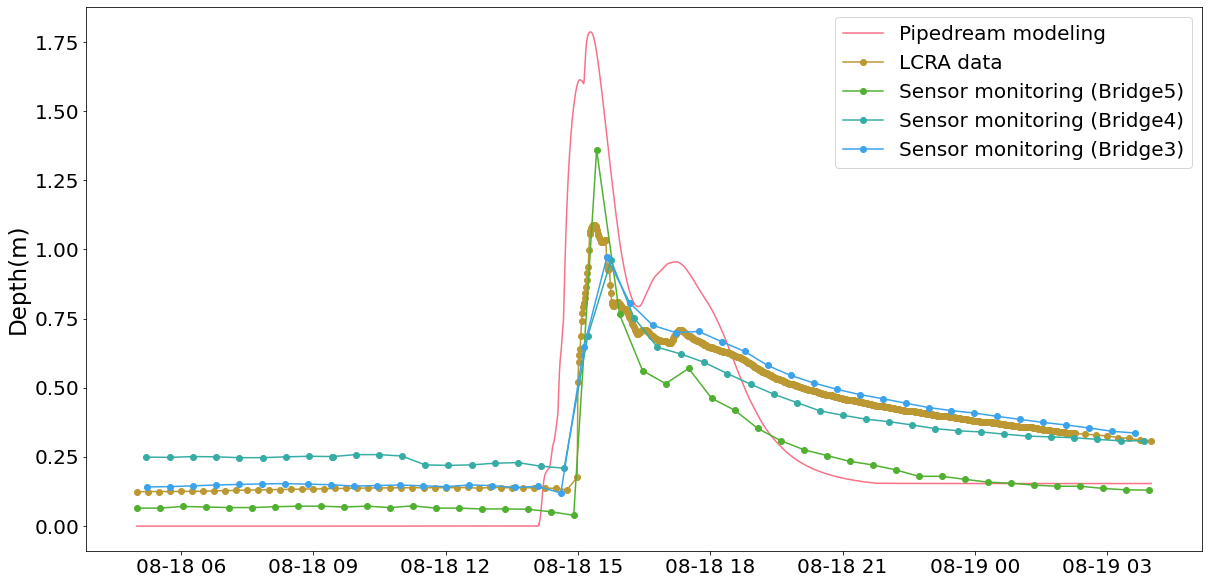

In [56]:
plot_simulation_monitoring_data(start_time,end_time)